In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as smf
import numpy as np
from math import *

In [182]:
df = pd.read_excel('picos.xlsx', sheet_name='covid', usecols=['data','casosNovos'])
dfmmq = pd.read_excel('picos.xlsx', sheet_name='covid', usecols=['data','casosAcumulado', 'casosNovos'])
mediamov = df.set_index('data')

In [183]:
#Calculo do ajuste via MMQ
def mmq (x, y):
    X = smf.add_constant(np.column_stack((x, x**2)))
    
    ajuste = smf.OLS(y, X)
    resultado = ajuste.fit()
    
    return resultado

y = dfmmq['casosAcumulado'].values
x_mmq = np.arange(21)
x = dfmmq['data'].values
cn = dfmmq['casosNovos'].values

arquivo = open('tabela.xlsx.csv', 'w+')

arquivo.write('data;A0(x^2);A1(x);A2(x^0);erro;previsao;casos novos;erro relativo\n')

previsoes = dict()
datas_boas = {pd.to_datetime('2022-05-20'), pd.to_datetime('2022-08-29'), pd.to_datetime('2022-10-24')}
datas_ruins = {pd.to_datetime('2022-01-04'), pd.to_datetime('2022-02-25'), pd.to_datetime('2022-06-27')}

for i in range (21, len(y)):
    y_mmq = y[i-21:i]
    results = mmq(x_mmq,y_mmq)
    a0 = results.params[2]
    a1 = results.params[1]
    a2 = results.params[0]
    previsao = lambda x: a0*x**2+a1*x+a2
    soma = 0
    for j in range (0, 21):
        soma += (previsao(j) - y[i-21+j])**2/21
        
    erro = sqrt(soma)
    if(i < len(y)-1):
        erro_relat = abs(previsao(22)-y[i+1])/y[i+1]
    else: erro_relat = 0
    data = pd.to_datetime(x[i-21])
    if(data in datas_boas or data in datas_ruins):
        previsoes[data] = [[previsao(k) for k in range (21)], [y[k-21+i] for k in range (21)], [x[i-21:i]]]
        
        
    
    arquivo.write(f'{data.date()};{results.params[2]:.4f};{results.params[1]:.4f};{results.params[0]:.4f}') 
    arquivo.write(f';{erro:.4f};{previsao(22):.4f};{cn[i-21]};{100*erro_relat:.4f}\n')  
    
arquivo.close()



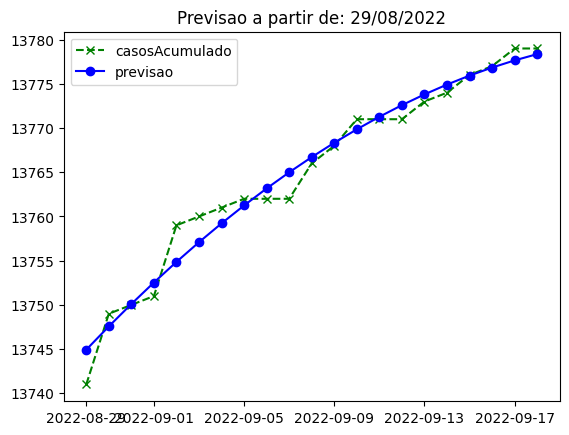

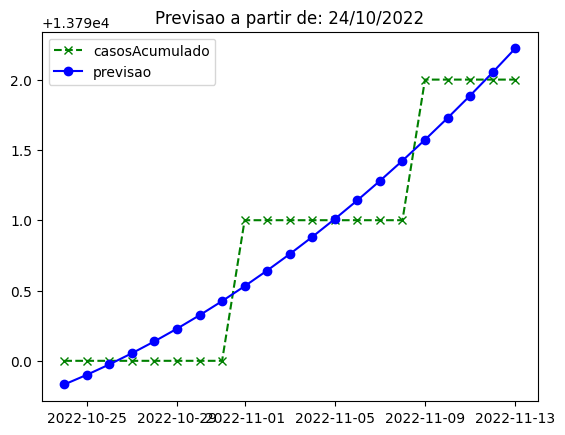

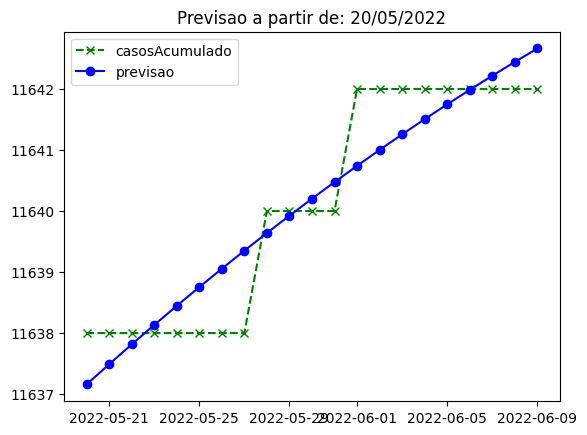

In [184]:
#Calculo das 3 previsoes boas
for data in datas_boas:

    dfdatas = pd.DataFrame({'casosAcumulado': previsoes[data][1], 'previsao': previsoes[data][0]}, index= pd.to_datetime(previsoes[data][2][0]).date)
    ax = dfdatas.plot(x_compat=True, rot=90, y = 'casosAcumulado', marker = 'x',linestyle='dashed', color = 'green', grid = True)
    dfdatas.plot(ax = ax, y = 'previsao', marker = 'o',linestyle='solid', color = 'blue')
    plt.title(f'Previsao a partir de: {pd.to_datetime(previsoes[data][2][0]).date[0].strftime("%d/%m/%Y")}')


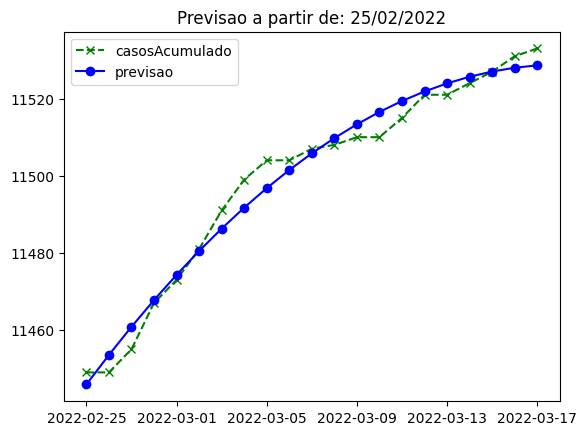

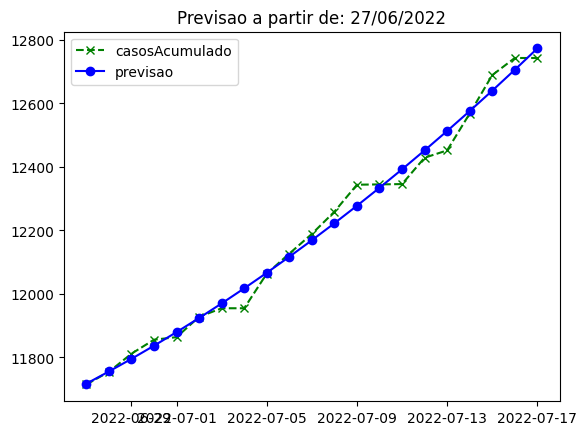

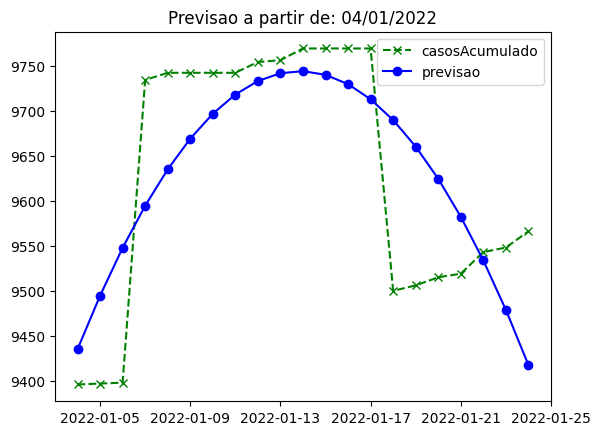

In [185]:
#Calculo das 3 previsoes ruins
for data in datas_ruins:

    dfdatas = pd.DataFrame({'casosAcumulado': previsoes[data][1], 'previsao': previsoes[data][0]}, index= pd.to_datetime(previsoes[data][2][0]).date)
    ax = dfdatas.plot(x_compat=True, rot=90, y = 'casosAcumulado', marker = 'x',linestyle='dashed', color = 'green', grid = True)
    dfdatas.plot(ax = ax, y = 'previsao', marker = 'o',linestyle='solid', color = 'blue')
    plt.title(f'Previsao a partir de: {pd.to_datetime(previsoes[data][2][0]).date[0].strftime("%d/%m/%Y")}')

In [186]:
dft = pd.read_csv('tabela.xlsx.csv', sep = ';')
dft

,data,A0(x^2),A1(x),A2(x^0),erro,previsao,casos novos,erro relativo
0,2022-01-01,-3.6932,84.6233,9263.4625,83.8403,9337.6454,0,2.2031
1,2022-01-02,-3.8174,83.3030,9300.6844,80.8548,9285.7177,0,2.9300
2,2022-01-03,-3.6598,76.2184,9357.2676,84.4674,9262.7528,0,3.3116
3,2022-01-04,-3.1746,62.6186,9435.0999,93.0461,9276.2190,1,3.3727
4,2022-01-05,-2.3785,42.7757,9533.4986,100.2223,9323.3578,1,2.9424
...,...,...,...,...,...,...,...,...
376,2023-01-12,-0.0124,1.6858,14383.0757,2.8524,14414.1583,0,0.0150
377,2023-01-13,-0.0262,1.9664,14383.3986,2.7400,14413.9583,0,0.0136
378,2023-01-14,-0.0392,2.1954,14384.1158,2.6488,14413.4488,0,0.0101
379,2023-01-15,-0.0489,2.3264,14385.3738,2.6003,14412.8786,0,0.0061


In [187]:
mediam = mediamov['casosNovos'].rolling(window = 7, center= False).mean()

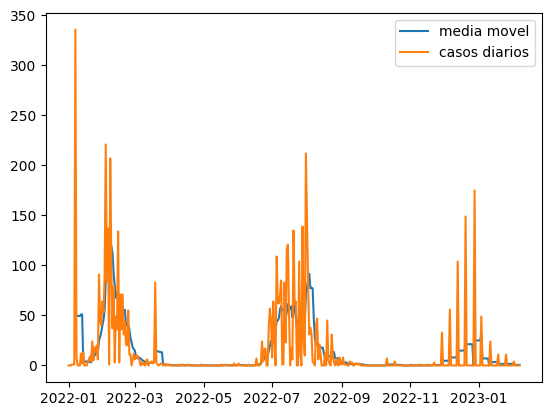

In [188]:
#Calculo das medias moveis
plt.plot(mediam, label = 'media movel')
plt.plot(mediamov['casosNovos'], label = 'casos diarios')
plt.legend()

